In [1]:
import pandas as pd
import numpy as np

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

In [2]:
data = pd.read_csv('kickstarter.csv', parse_dates=['launched'])

In [3]:
data = data.assign(outcome=(data.state == 'successful').astype(int))
data.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0


In [4]:
data.shape

(378661, 16)

In [5]:
data = data.query("state != 'live'")
data.shape

(375862, 16)

In [6]:
data = data.assign(hour=data.launched.dt.hour,
                  day=data.launched.dt.day,
                  month=data.launched.dt.month,
                  year=data.launched.dt.year)
data.shape

(375862, 20)

In [7]:
cat_features = ['category', 'currency', 'country']

In [8]:
encoder = ce.CountEncoder(cols=cat_features)

In [9]:
num_X = data[['hour', 'day', 'month', 'year', 'goal', 'outcome']]
num_X.head()

,hour,day,month,year,goal,outcome
0,12,11,8,2015,1000.0,0
1,4,2,9,2017,30000.0,0
2,0,12,1,2013,45000.0,0
3,3,17,3,2012,5000.0,0
4,8,4,7,2015,19500.0,0


In [10]:
X = num_X.join(data[cat_features])

X.head()

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US
3,3,17,3,2012,5000.0,0,Music,USD,US
4,8,4,7,2015,19500.0,0,Film & Video,USD,US


In [11]:
valid_fraction = 0.1
valid_size = int(len(X) * valid_fraction)

train = X[: -2* valid_size]
valid = X[-2*valid_size: -valid_size]
test = X[-valid_size:]
test.shape

(37586, 9)

In [12]:
train.head(2)

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US


In [13]:
encoder.fit(train[cat_features])

CountEncoder(cols=['category', 'currency', 'country'],
             combine_min_nan_groups=True, drop_invariant=False,
             handle_missing='count', handle_unknown=None, min_group_name=None,
             min_group_size=None, normalize=False, return_df=True, verbose=0)

In [14]:
count_train = train.join(encoder.transform(train[cat_features]).add_suffix('_count'))
count_valid = valid.join(encoder.transform(valid[cat_features]).add_suffix('_count'))
count_test = test.join(encoder.transform(test[cat_features]).add_suffix('_count'))

count_train.head()

,hour,day,month,year,goal,outcome,category,currency,country,category_count,currency_count,country_count
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,1055,27142,26770
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,4160,234783,232607
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,4160,234783,232607
3,3,17,3,2012,5000.0,0,Music,USD,US,12485,234783,232607
4,8,4,7,2015,19500.0,0,Film & Video,USD,US,8076,234783,232607


In [15]:
param = {'num_leaves': 65, 'objective': 'binary', 'metrics': 'auc'}
num_rounds = 1000

In [16]:
features = count_train.columns.drop(['outcome', 'category', 'currency', 'country'])
features

Index(['hour', 'day', 'month', 'year', 'goal', 'category_count',
       'currency_count', 'country_count'],
      dtype='object')

In [17]:
dtrain = lgb.Dataset(count_train[features], train['outcome'])
dvalid = lgb.Dataset(count_valid[features], valid['outcome'])

In [18]:
model = lgb.train(param, dtrain, num_rounds, valid_sets=[dvalid], early_stopping_rounds=5)

[LightGBM] [Info] Number of positive: 107340, number of negative: 193350
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 300690, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356979 -> initscore=-0.588501
[LightGBM] [Info] Start training from score -0.588501
[1]	valid_0's auc: 0.693797
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.696566
[3]	valid_0's auc: 0.703284
[4]	valid_0's auc: 0.706447
[5]	valid_0's auc: 0.708446
[6]	valid_0's auc: 0.709716
[7]	valid_0's auc: 0.710423
[8]	valid_0's auc: 0.711094
[9]	valid_0's auc: 0.712814
[10]	valid_0's auc: 0.713492
[11]	valid_0's auc: 0.714588
[12]	valid_0's auc: 0.715286
[13]	valid_0's auc: 0.716922
[14]	valid

In [19]:
preds = model.predict(count_test[features])
score = metrics.roc_auc_score(count_test['outcome'], preds)
score

0.7470107880058254

# Some FeAturE eNGineeRing

### INterActions

In [20]:
new_X = X.copy()
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US


In [21]:
new_X.shape

(375862, 9)

In [22]:
# New Feature >> 'country_categ'
new_X['country_categ'] = new_X.country + '_' + new_X.category
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,GB_Poetry
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,US_Narrative Film
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,US_Narrative Film


In [23]:
# New Feature >> 'category_curren'
new_X = new_X.assign(category_curren=(new_X.category + '_' + new_X.currency))
new_X.head(3)

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,GB_Poetry,Poetry_GBP
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD


# Number of Projects in last week

### Time Series and Rolling Window Def

In [24]:
data[['launched']].head(3)

,launched
0,2015-08-11 12:12:28
1,2017-09-02 04:43:57
2,2013-01-12 00:20:50


In [25]:
data[['launched', 'category']].dtypes

launched    datetime64[ns]
category            object
dtype: object

In [26]:
# Create series with Timestamp index
launched = pd.Series(data.index, index=data.launched, name='count_7_days').sort_index()
launched.head(10)

# Series contains the index values
# To be returned later

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
Name: count_7_days, dtype: int64

In [27]:
# With the TImestamp index
# Use .Rolling def to select time periods
count_7_days = launched.rolling('7d').count() - 1

# The first 7 rows have incorrect data
count_7_days[7:].head(10)

launched
2009-04-21 21:02:48    0.0
2009-04-23 00:07:53    1.0
2009-04-24 21:52:03    2.0
2009-04-25 17:36:21    3.0
2009-04-27 14:10:39    4.0
2009-04-28 13:55:41    5.0
2009-04-29 02:04:21    5.0
2009-04-29 02:58:50    6.0
2009-04-29 04:37:37    7.0
2009-04-29 05:26:32    8.0
Name: count_7_days, dtype: float64

In [28]:
# Plot the days
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\George Kang'ethe\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


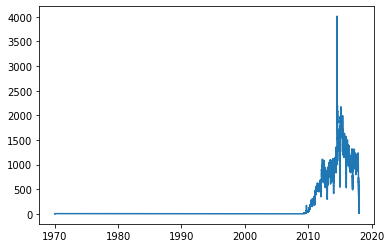

In [29]:
plt.plot(count_7_days)

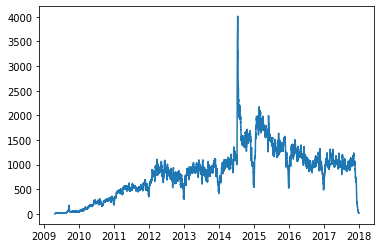

In [30]:
# As you can see
# Remove the first 7 entries
plt.plot(count_7_days[7:])

In [31]:
# REturn the index of the original dataframe 
# Join to other features
count_7_days.index = launched.values
count_7_days.head()

# Now the indices are all joumbled up
# use .reindex def

94579     0.0
319002    1.0
247913    2.0
48147     3.0
75397     4.0
Name: count_7_days, dtype: float64

In [32]:
count_7_days = count_7_days.reindex(data.index)
count_7_days.head()

0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
Name: count_7_days, dtype: float64

### Add 'count_7_days' as a new feAtuRE

In [33]:
data_2 = new_X.join(count_7_days)
data_2.head()

,hour,day,month,year,goal,outcome,category,currency,country,country_categ,category_curren,count_7_days
0,12,11,8,2015,1000.0,0,Poetry,GBP,GB,GB_Poetry,Poetry_GBP,1409.0
1,4,2,9,2017,30000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD,957.0
2,0,12,1,2013,45000.0,0,Narrative Film,USD,US,US_Narrative Film,Narrative Film_USD,739.0
3,3,17,3,2012,5000.0,0,Music,USD,US,US_Music,Music_USD,907.0
4,8,4,7,2015,19500.0,0,Film & Video,USD,US,US_Film & Video,Film & Video_USD,1429.0


In [34]:
print(count_7_days.min())
print(count_7_days.max())
print(count_7_days.mean())
print(count_7_days.std())

0.0
4012.0
1122.375970435958
480.28147310748534


## ANother FeatuRE
### Time_since last Project

In [35]:
df = data[['category', 'launched']].sort_values('launched')

df.head(10)

,category,launched
94579,Theater,1970-01-01 01:00:00
319002,Publishing,1970-01-01 01:00:00
247913,Music,1970-01-01 01:00:00
48147,Art,1970-01-01 01:00:00
75397,Film & Video,1970-01-01 01:00:00
2842,Film & Video,1970-01-01 01:00:00
273779,Design,1970-01-01 01:00:00
169268,Fashion,2009-04-21 21:02:48
322000,Shorts,2009-04-23 00:07:53
138572,Illustration,2009-04-24 21:52:03


In [36]:
def time_since_last_project(series):
    
    return series.diff().dt.total_seconds() / 3600

In [43]:
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(20)

,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


In [38]:
# NaN is where there is no preceding project in the category
# HAve to IMputE with mean or median
# Plus REset the index
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(data.index)
timedeltas.head(10)

,launched
0,18.606111
1,5.592778
2,1.313611
3,0.635000
4,16.661389
5,2.629722
6,0.367500
7,12.286111
8,14.243611
9,0.174722


## More ENginEERing
# TransFoRMing numericals

(array([8.4897e+04, 5.9602e+04, 4.8113e+04, 2.2265e+04, 1.3347e+04,
        2.8766e+04, 8.3240e+03, 1.6121e+04, 3.2350e+03, 3.0600e+03,
        1.3689e+04, 1.7060e+03, 1.1163e+04, 1.1700e+03, 1.0510e+03,
        7.9370e+03, 9.1900e+02, 3.8340e+03, 6.5800e+02, 6.5000e+02,
        3.4920e+03, 4.0100e+02, 1.7090e+03, 2.6900e+02, 4.7400e+02,
        9.5520e+03, 2.1200e+02, 1.1100e+03, 1.7800e+02, 1.8200e+02,
        2.1630e+03, 1.3900e+02, 9.2300e+02, 1.5200e+02, 1.8700e+02,
        8.7300e+02, 9.5000e+01, 2.1440e+03, 1.1000e+02, 1.3800e+02,
        1.1290e+03, 7.7000e+01, 5.1700e+02, 7.8000e+01, 1.3300e+02,
        4.7100e+02, 5.4000e+01, 2.6200e+02, 6.9000e+01, 4.9570e+03]),
 array([     0.,   2000.,   4000.,   6000.,   8000.,  10000.,  12000.,
         14000.,  16000.,  18000.,  20000.,  22000.,  24000.,  26000.,
         28000.,  30000.,  32000.,  34000.,  36000.,  38000.,  40000.,
         42000.,  44000.,  46000.,  48000.,  50000.,  52000.,  54000.,
         56000.,  58000.,  60000.,

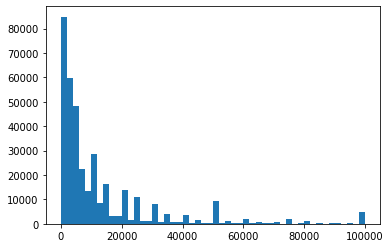

In [39]:
# Explore the goal col and see distribution
plt.hist(data_2.goal, range=(0, 100000), bins=50)

(array([ 3645.,  9487., 20668., 29701., 17321., 21867., 30924., 19214.,
        35177., 12538., 13848., 11858., 28638.,  8650.,  2790., 16369.,
         3845., 14295.,  2121., 11280.,  1766.,  8271.,  1088.,  4164.,
          982.,  3850.,  1838., 10148.,   271.,  1272.,  2356.,  1060.,
          341.,   975.,  2321.,  1255.,   611.,   629.,   357.,  5002.,
          105.,   286.,   154.,   507.,   582.,   276.,   146.,    70.,
         1758.,   217.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.,
        264., 272., 280., 288., 296., 304., 312., 320., 328., 336., 344.,
        352., 360., 368., 376., 384., 392., 400.]),
 <a list of 50 Patch objects>)

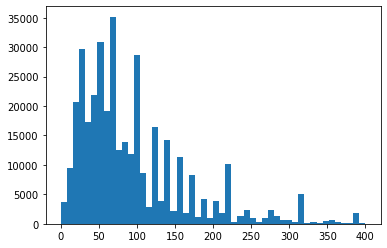

In [40]:
plt.hist(np.sqrt(data_2.goal), range=(0, 400), bins=50)

(array([4.2500e+02, 2.4000e+01, 2.9000e+01, 1.6900e+02, 6.4800e+02,
        5.9400e+02, 5.3200e+02, 1.0440e+03, 5.3700e+02, 3.0770e+03,
        3.9450e+03, 9.1190e+03, 1.7326e+04, 2.6235e+04, 2.0448e+04,
        3.3474e+04, 4.0454e+04, 6.3305e+04, 4.3431e+04, 3.7443e+04,
        2.7220e+04, 1.8596e+04, 9.7680e+03, 9.0540e+03, 3.6960e+03,
        1.8160e+03, 1.4580e+03, 9.3000e+02, 2.8800e+02, 3.4500e+02,
        1.5400e+02, 5.7000e+01, 7.4000e+01, 4.8000e+01, 2.5000e+01,
        2.8000e+01, 4.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23

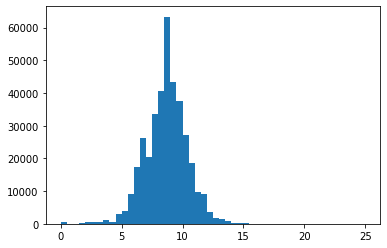

In [45]:
plt.hist(np.log(data_2.goal), range=(0, 25), bins=50)

In [ ]:
cat_cols = [col for col in new_X.columns if new_X[col].dtype == 'object']
cat_cols

In [ ]:
num_sub = new_X.drop(cat_cols, axis=1)
num_sub.head(2)

In [ ]:
valid_fraction = 0.1
valid_size = int(len(new_X) * valid_fraction)

train = new_X[: -2* valid_size]
valid = new_X[-2*valid_size: -valid_size]
test = new_X[-valid_size:]
test.head(2)

In [ ]:
my_enc = ce.CountEncoder(cols=cat_cols)
my_enc.fit(train[cat_cols])

In [ ]:
train_2 = train.join(my_enc.transform(train[cat_cols]).add_suffix('_count'))
valid_2 = valid.join(my_enc.transform(valid[cat_cols]).add_suffix('_count'))
test_2 = test.join(my_enc.transform(test[cat_cols]).add_suffix('_count'))

test_2.head()

In [ ]:
test_2.head(2)

In [ ]:
features = train_2.columns.drop(['outcome', 'category', 'currency', 'country', 'country_categ', 'category_curren'])
features

In [ ]:
dtrain = lgb.Dataset(train_2[features], train_2['outcome'])
dvalid = lgb.Dataset(valid_2[features], valid_2['outcome'])
dtrain

In [ ]:
param = {'num_leaves': 65, 'objective': 'binary', 'metrics': 'auc'}
num_rounds = 1000

In [ ]:
model_2 = lgb.train(param, dtrain, num_rounds, valid_sets=[dvalid], early_stopping_rounds=5, verbose_eval=False)

print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print(f"Best valid score: {model_2.best_score}")

In [ ]:
preds_2 = model_2.predict(test_2[features])
preds_2

In [ ]:
score_2 = metrics.roc_auc_score(test_2['outcome'], preds_2)
print('The Test Score:')
score_2